# Credit Card Approval Prediction


- This notebook had codes for a ML model to predict the credi card approval status for a client suing the data available in this link [DATA](https://www.kaggle.com/rikdifos/credit-card-approval-prediction)
- The main focus of this note is not on the model accuracy but the various approaches like data pre-processing techniques, auto ML libraries for EDA, outlier treatment, handling class imbalance, dimensionality reduction using PCA and experiment various models as listed below

  - LogisticRegression
  - KNeighbors
  - SVC
  - DecisionTree
  - RandomForest
  - XGBoost

In [1]:
# loading basic libraries
import numpy as np
import pandas as pd
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

# Data Viz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go

# Stats & ML
from scipy import stats
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import balanced_accuracy_score
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Auto ML
import sweetviz as sv
from pandas_profiling import ProfileReport
import scorecardpy as sc

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data
application = pd.read_csv('*/application_record.csv')
credit = pd.read_csv('*/Credit Card Approval/credit_record.csv')

In [4]:
application = application.sort_values(by=['ID'],ascending=True)
application.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [5]:
application.shape

(438557, 18)

In [6]:
# data types
application.dtypes

ID                       int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED            int64
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
dtype: object

## Data Cleaning

In [7]:
# Helper Function - Missing data check
def missing_data(data):
    missing = data.isnull().sum()
    available = data.count()
    total = (missing + available)
    percent = (data.isnull().sum()/data.isnull().count()*100).round(4)
    return pd.concat([missing, available, total, percent], axis=1, keys=['Missing', 'Available', 'Total', 'Percent']).sort_values(['Missing'], ascending=False)

def drop_missing(df):
    thresh = len(df) * 0.6
    df.dropna(axis=1, thresh=thresh, inplace=True)
    return df
def remove_outliers(df, column_name):
    low = np.quantile(df[column_name], 0.05)
    high = np.quantile(df[column_name], 0.95)
    return df[df[column_name].between(low, high, inclusive=True)]

def to_category(df):
    cols = df.select_dtypes(include='object').columns
    for col in cols:
        ratio = len(df[col].value_counts()) / len(df)
        if ratio < 0.05:
            df[col] = df[col].astype('category')
    return df

In [8]:
# missing data check
missing_data(application)

,Missing,Available,Total,Percent
OCCUPATION_TYPE,134203,304354,438557,30.601
ID,0,438557,438557,0.000
CODE_GENDER,0,438557,438557,0.000
FLAG_EMAIL,0,438557,438557,0.000
FLAG_PHONE,0,438557,438557,0.000
FLAG_WORK_PHONE,0,438557,438557,0.000
FLAG_MOBIL,0,438557,438557,0.000
DAYS_EMPLOYED,0,438557,438557,0.000
DAYS_BIRTH,0,438557,438557,0.000
NAME_HOUSING_TYPE,0,438557,438557,0.000


In [9]:
# Duplicate values (rows) check
duplicate_application = application[application.duplicated(['ID'], keep='last')]
duplicate_application.count()

ID                     47
CODE_GENDER            47
FLAG_OWN_CAR           47
FLAG_OWN_REALTY        47
CNT_CHILDREN           47
AMT_INCOME_TOTAL       47
NAME_INCOME_TYPE       47
NAME_EDUCATION_TYPE    47
NAME_FAMILY_STATUS     47
NAME_HOUSING_TYPE      47
DAYS_BIRTH             47
DAYS_EMPLOYED          47
FLAG_MOBIL             47
FLAG_WORK_PHONE        47
FLAG_PHONE             47
FLAG_EMAIL             47
OCCUPATION_TYPE        32
CNT_FAM_MEMBERS        47
dtype: int64

In [10]:
duplicate_application = duplicate_application.sort_values(by=['ID'])

Observation:-
- Duplicate entries are observed with same client number but different gender and other details. This seems unlikely and possible re-entry with corrected details
- Hence deleting first entries and keeping the latest ones

In [11]:
application_clean = application.drop_duplicates(subset=['ID'], keep='last')
print("Original Data= ",application.shape)
print("Cleaned Data = ",application_clean.shape)

Original Data=  (438557, 18)
Cleaned Data =  (438510, 18)


In [12]:
application_clean.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385100e+05,438510.000000,4.385100e+05,438510.000000,438510.000000,438510.0,438510.000000,438510.000000,438510.000000,438510.000000
mean,6.022035e+06,0.427386,1.875243e+05,-15997.892817,60561.988377,1.0,0.206125,0.287768,0.108198,2.194470
std,5.714962e+05,0.724874,1.100874e+05,4185.001036,138766.425430,0.0,0.404522,0.452723,0.310631,0.897192
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609362e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047720e+06,0.000000,1.611000e+05,-15630.000000,-1468.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.454161e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [13]:
#application_clean.to_csv('application_clean.csv',index=False)

In [14]:
credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [15]:
credit['STATUS'].value_counts()

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64

#### Data Dictionary:-

1. ID: Unique Id of the row in application record.
2. MONTHS_BALANCE: The number of months from record time.
3. STATUS: Credit status for this month.
  - X: No loan for the month
  - C: paid off that month 
  - 0: 1-29 days past due 
  - 1: 30-59 days past due 
  - 2: 60-89 days overdue
  - 3: 90-119 days overdue 
  - 4: 120-149 days overdue 
  - 5: Overdue or bad debts, write-offs for more than 150 days 

In [16]:
# missing data check
missing_data(credit)

,Missing,Available,Total,Percent
ID,0,1048575,1048575,0.0
MONTHS_BALANCE,0,1048575,1048575,0.0
STATUS,0,1048575,1048575,0.0


In [17]:
credit.describe()

,ID,MONTHS_BALANCE
count,1.048575e+06,1.048575e+06
mean,5.068286e+06,-1.913700e+01
std,4.615058e+04,1.402350e+01
min,5.001711e+06,-6.000000e+01
25%,5.023644e+06,-2.900000e+01
50%,5.062104e+06,-1.700000e+01
75%,5.113856e+06,-7.000000e+00
max,5.150487e+06,0.000000e+00


In [18]:
credit.shape

(1048575, 3)

In [19]:
credit.dtypes

ID                 int64
MONTHS_BALANCE     int64
STATUS            object
dtype: object

In [20]:
# credit['DATA_HIST'] = np.where(credit['MONTHS_BALANCE']< -36, True, False)


def percent(column,decimals=2):
    assert decimals >= 0
    return (round(column*100,decimals).astype(str) + "%")

# percent(credit['DATA_HIST'].value_counts(normalize=True),decimals=1)

In [21]:
'''credit['DATA_HIST'].value_counts()
# Approximately 14% of the data points are older than 3 years and hence it will not make sense to include that 
in our modelling process. Hence data which beloning to last 3 years only will be considered.
'''

"credit['DATA_HIST'].value_counts()\n# Approximately 14% of the data points are older than 3 years and hence it will not make sense to include that \nin our modelling process. Hence data which beloning to last 3 years only will be considered.\n"

In [22]:
'''credit_new = credit.loc[credit['DATA_HIST'] == False]
credit_new.shape'''

"credit_new = credit.loc[credit['DATA_HIST'] == False]\ncredit_new.shape"

In [23]:
# find the tenure for each entry
credit['Tenure'] = credit['MONTHS_BALANCE'].apply(lambda x : x*(-1))
credit.shape

(1048575, 4)

In [24]:
credit = credit.sort_values(by=['ID','Tenure'],ascending=True)
credit.head(10)

,ID,MONTHS_BALANCE,STATUS,Tenure
0,5001711,0,X,0
1,5001711,-1,0,1
2,5001711,-2,0,2
3,5001711,-3,0,3
4,5001712,0,C,0
5,5001712,-1,C,1
6,5001712,-2,C,2
7,5001712,-3,C,3
8,5001712,-4,C,4
9,5001712,-5,C,5


In [25]:
credit_new = credit.groupby('ID').agg(max).reset_index()
credit_new.head()

,ID,MONTHS_BALANCE,STATUS,Tenure
0,5001711,0,X,3
1,5001712,0,C,18
2,5001713,0,X,21
3,5001714,0,X,14
4,5001715,0,X,59


In [26]:
credit_new = credit_new[['ID', 'MONTHS_BALANCE', 'Tenure', 'STATUS']]

In [27]:
#credit_new.to_csv('credit_new.csv',index=False)

In [28]:
credit_new.shape

(45985, 4)

In [29]:
df = pd.merge(application_clean, credit_new, how='inner', on=['ID'])
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,Tenure,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,15,X
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,14,X
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,29,X
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,4,X
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-22,26,X


In [30]:
#application_df.to_csv('application_df.csv',index=False)

In [31]:
df.shape

(36457, 21)

In [32]:
df['STATUS'].value_counts()

X    19648
C    11759
0     4282
1      660
5       48
2       48
3        9
4        3
Name: STATUS, dtype: int64

##### Reasons for Credit Card Rejection/Disapproval

The reasons for a credit card rejection in India have been provided based on previous rejection experiences that applicant have faced and these reasons have found to be the most common across all major banks in the country.

  - Low credit score
  - Unstable employment
  - Insufficient income
  - Working in a delisted private company
  - Not falling into the age limit
  - Living in an address which is present in the defaulter list

- [creditmantri](https://www.creditmantri.com/credit-card-rejection/)
- [Balance](https://www.thebalance.com/denied-credit-card-application-960247)
- [Late Payment](https://www.thebalance.com/when-does-a-late-payment-go-on-my-credit-report-960434)

![Credit Score](https://www.myfico.com/static/images/education/ce_FICO-Score-chart.png)


Based on above reference information, applicants who have past record for delayed credit payment greater than 59 days will have their applications rejected

In [33]:
# replacing X & C by 0
df['STATUS'].replace('X', 0, inplace=True)
df['STATUS'].replace('C', 0, inplace=True)
df['STATUS'] = df['STATUS'].astype('int')

percent(df['STATUS'].value_counts(normalize=True, sort=False),decimals=2)

0    97.89%
1     1.81%
2     0.13%
3     0.02%
4     0.01%
5     0.13%
Name: STATUS, dtype: object

In [34]:
df['STATUS'] = df['STATUS'].apply(lambda x: 1 if x >= 2 else 0)
percent(df['STATUS'].value_counts(normalize=True, sort=False),decimals=2)

0    99.7%
1     0.3%
Name: STATUS, dtype: object

In [35]:
df['STATUS'].value_counts(sort=False)

0    36349
1      108
Name: STATUS, dtype: int64

In [36]:
df = df.drop(['MONTHS_BALANCE'], axis=1)
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Tenure,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,15,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,14,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,29,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,4,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,26,0


In [37]:
#renaming the column headers for easy understanding

df.rename(columns={'ID': 'User_id', 'CODE_GENDER':'Gender',
                   'FLAG_OWN_CAR':'Car', 'FLAG_OWN_REALTY':'Realty_owned', 'CNT_CHILDREN':'Children_count',
                   'AMT_INCOME_TOTAL':'Income_amount', 'NAME_INCOME_TYPE':'Income_type', 'NAME_EDUCATION_TYPE':'Education',
                   'NAME_FAMILY_STATUS':'Family_status', 'NAME_HOUSING_TYPE':'Housing_type', 'DAYS_BIRTH':'Days_birth',
                   'DAYS_EMPLOYED':'Days_employed', 'FLAG_MOBIL':'Mobile', 'FLAG_WORK_PHONE':'Work_phone',
                   'FLAG_PHONE':'Phone', 'FLAG_EMAIL':'Email', 'OCCUPATION_TYPE':'Occupation_type',
                   'CNT_FAM_MEMBERS':'Family_members','Tenure':'Tenure', 'STATUS':'Reject_Status'}, inplace=True)
df.head(2)

,User_id,Gender,Car,Realty_owned,Children_count,Income_amount,Income_type,Education,Family_status,Housing_type,Days_birth,Days_employed,Mobile,Work_phone,Phone,Email,Occupation_type,Family_members,Tenure,Reject_Status
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,15,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,14,0


In [38]:
# Analyzing the dataset using sweetviz library
advert_report = sv.analyze(df)

# Display the report
advert_report.show_html('CreditCard.html')

                                             |          | [  0%]   00:00 -> (? left)

Report CreditCard.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [39]:
# Analyzing the dataset using pandas profiling library
application_profile = ProfileReport(df, 
                        title='Pandas Profiling Report for Application Data', 
                        html={'style':{'full_width':True}}) 

application_profile.to_widgets()

Summarize dataset:   0%|          | 0/34 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

#### Observation
- All applicants in merged dataset own a mobile phone and hence the column "Mobile" seem to be of no importance. Hence it can be dropped
- Majority of tyhe applicants are female
- Occupation type column has 30% missing values and hence can either dropped or imputed (missing values as unknown)
- Most of the categorical columns/features seem to be binary in nature
- Major class imbalance observed. Only 0.26% of applicants belong to rejected category
- Income and number of family members seem to have extreme values/data points (possibly outliers)

In [40]:
# dropping feature "mobile"
df = df.drop(['Mobile'], axis=1)
df.shape

(36457, 19)

In [41]:
# Fill missing values of feature occupation type with unknown
df["Occupation_type"].fillna("Unknown", inplace = True)
df["Occupation_type"].value_counts()

Unknown                  11323
Laborers                  6211
Core staff                3591
Sales staff               3485
Managers                  3012
Drivers                   2138
High skill tech staff     1383
Accountants               1241
Medicine staff            1207
Cooking staff              655
Security staff             592
Cleaning staff             551
Private service staff      344
Low-skill Laborers         175
Waiters/barmen staff       174
Secretaries                151
HR staff                    85
Realty agents               79
IT staff                    60
Name: Occupation_type, dtype: int64

In [42]:
df = (df.pipe(to_category))
df.dtypes

User_id               int64
Gender             category
Car                category
Realty_owned       category
Children_count        int64
Income_amount       float64
Income_type        category
Education          category
Family_status      category
Housing_type       category
Days_birth            int64
Days_employed         int64
Work_phone            int64
Phone                 int64
Email                 int64
Occupation_type    category
Family_members      float64
Tenure                int64
Reject_Status         int64
dtype: object

In [43]:
# converting 'Days_birth' and 'Days_employed' to more readable format

df['Age'] = df['Days_birth'].apply(lambda x: round(x/-365,0))
df['Years_employed'] = df['Days_employed'].apply(lambda x: round(x/-365,0) if x<0 else 0)
df = df.drop(columns=["Days_birth","Days_employed"])
df.head()

,User_id,Gender,Car,Realty_owned,Children_count,Income_amount,Income_type,Education,Family_status,Housing_type,Work_phone,Phone,Email,Occupation_type,Family_members,Tenure,Reject_Status,Age,Years_employed
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,Unknown,2.0,15,0,33.0,12.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,Unknown,2.0,14,0,33.0,12.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2.0,29,0,59.0,3.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,4,0,52.0,8.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,26,0,52.0,8.0


# Exploratory Data Analysis

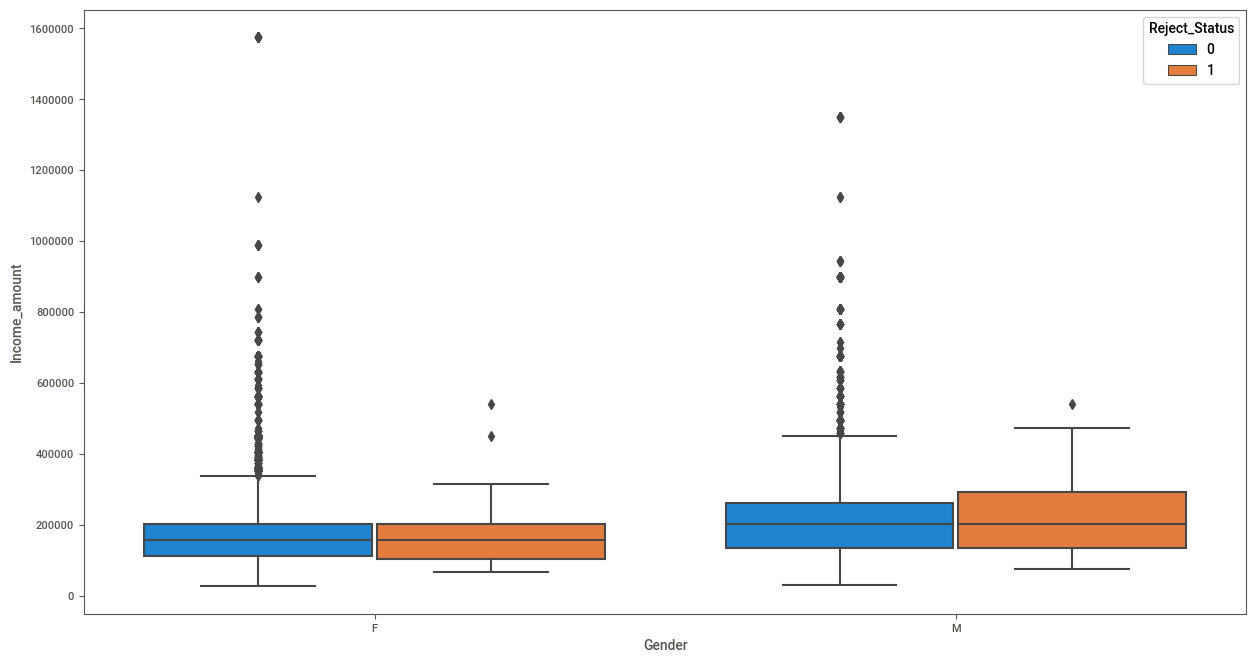

In [44]:
# income data

#fig = px.box(df, x="Gender", y="income_amount", color="Gender")
#fig.update_traces(quartilemethod="exclusive") #https://www.scribbr.com/statistics/interquartile-range/
#fig.show()

plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Gender", y="Income_amount", hue = "Reject_Status",data=df)

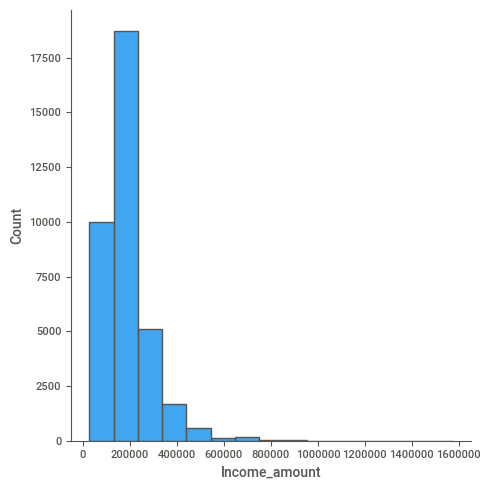

In [45]:
ax1 = sns.displot(df, x="Income_amount", bins=15)

##### Oulier Treatment
Common methods include Box plot, scatter plot, Z score, IQR score etc.
<br>
- **Deleting observations:** We delete outlier values if it is due to data entry error, data processing error or outlier observations are very small in numbers. We can also use trimming at both ends to remove outliers.
<br>
- **Transforming and binning values:** Transforming variables can also eliminate outliers. Natural log of a value reduces the variation caused by extreme values. Binning is also a form of variable transformation. Decision Tree algorithm allows to deal with outliers well due to binning of variable. We can also use the process of assigning weights to different observations.
<br>
- **Imputing:** Like imputation of missing values, we can also impute outliers. We can use mean, median, mode imputation methods. Before imputing values, we should analyse if it is natural outlier or artificial. If it is artificial, we can go with imputing values. We can also use statistical model to predict values of outlier observation and after that we can impute it with predicted values.
<br>
- **Treat separately:** If there are significant number of outliers, we should treat them separately in the statistical model. One of the approach is to treat both groups as two different groups and build individual model for both groups and then combine the output.
<br>
<br>

#### Observations
- Outliers in income are found in approved class than rejected. Hence removing extreme values might not affect the model performance in detecting the reject cases

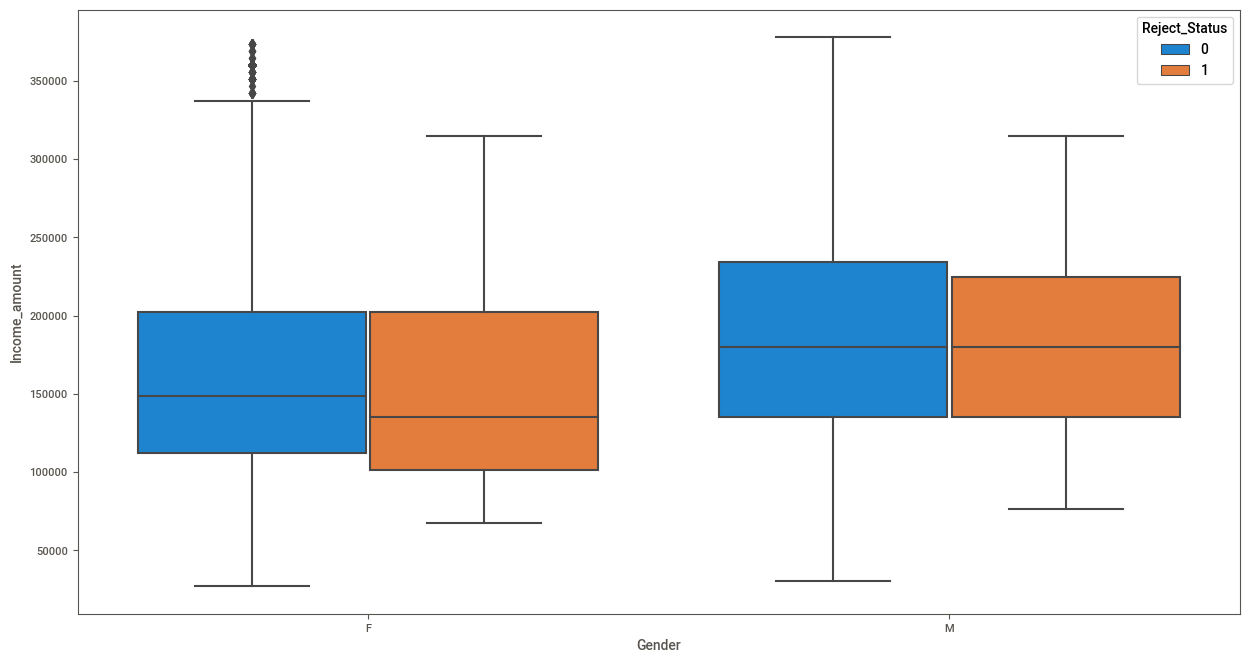

In [46]:
# z score method
'''z = np.abs(stats.zscore(df))
threshold = 3
print(np.where(z > 3))
'''

# IQR Method
def remove_outlier(col):
    q25 = col.quantile(0.25)
    q75 = col.quantile(0.75)
    iqr = q75 - q25
    cutoff = iqr*x
    lower = q25 - cutoff
    upper = q75 + cutoff
    return lower, upper

#Remove outliers for Income for 1.5 * IQR
x=1.5
lower_1, upper_1 = remove_outlier(df['Income_amount'])
df_IQR1 = df.loc[(df['Income_amount'] > lower_1) & (df['Income_amount'] < upper_1)]
plt.figure(figsize=(15,8))
ax1 = sns.boxplot(x="Gender", y="Income_amount", hue = "Reject_Status",data=df_IQR1)

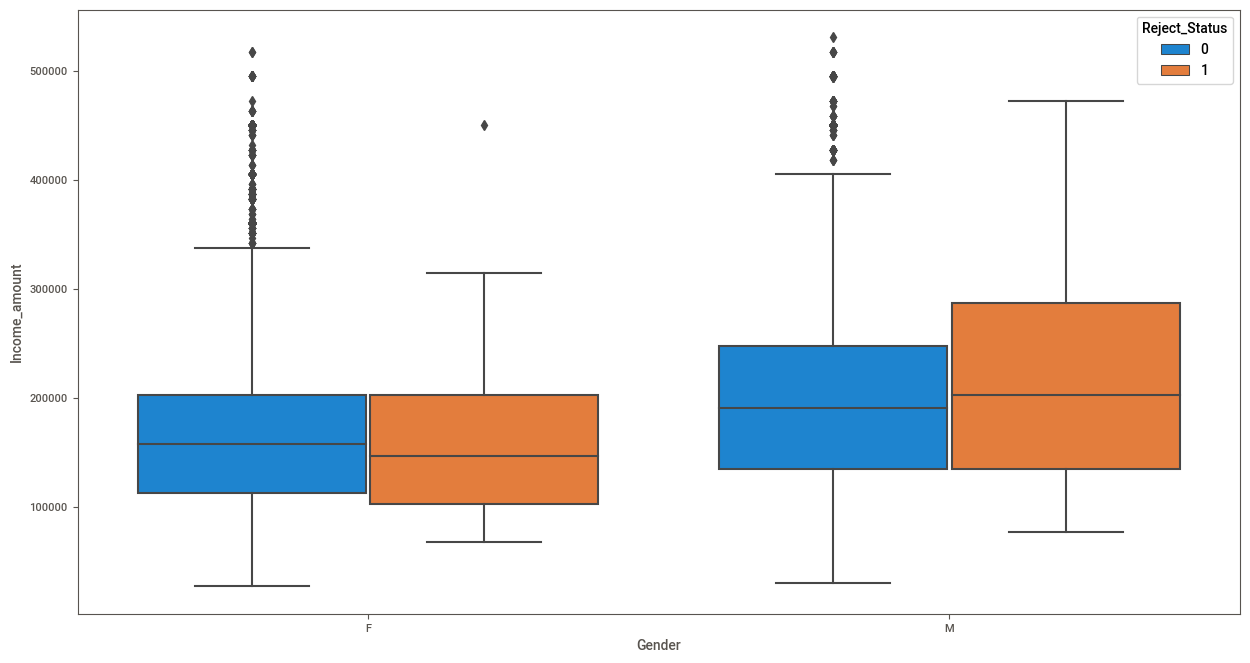

In [47]:
#Remove outliers for Income for 3 * IQR
x=3
lower_1a, upper_1a = remove_outlier(df['Income_amount'])
df_IQR2 = df.loc[(df['Income_amount'] > lower_1a) & (df['Income_amount'] < upper_1a)]
plt.figure(figsize=(15,8))
ax2 = sns.boxplot(x="Gender", y="Income_amount", hue = "Reject_Status",data=df_IQR2)

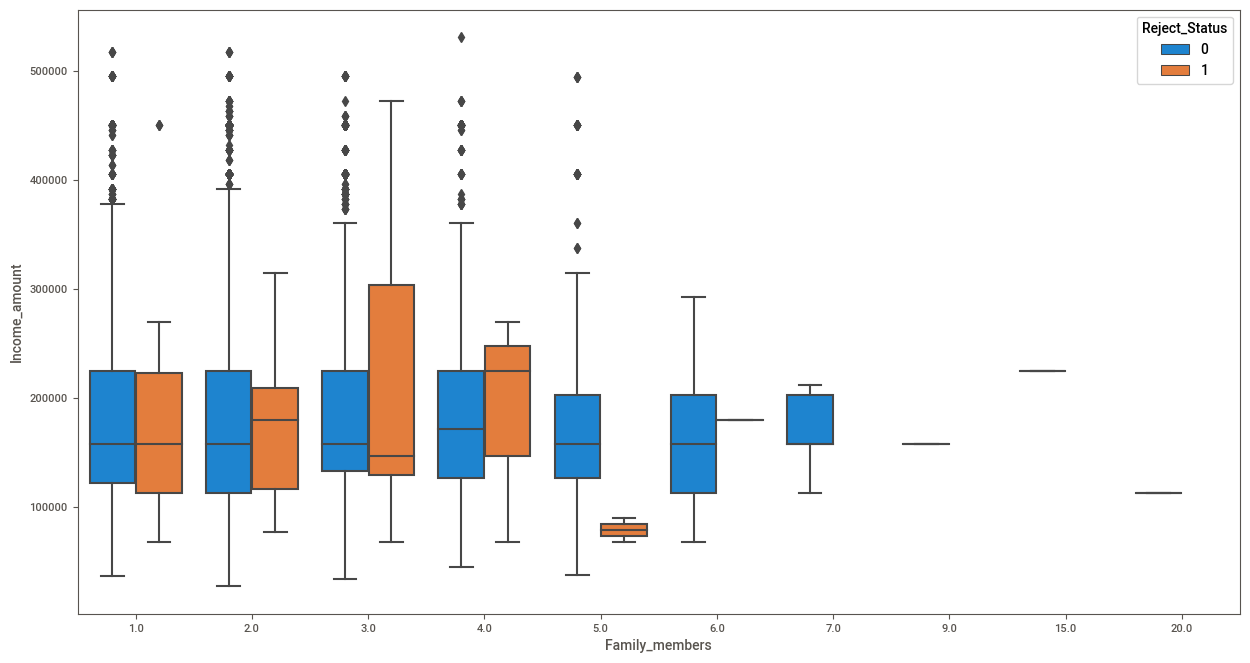

In [48]:
plt.figure(figsize=(15,8))
ax3 = sns.boxplot(x="Family_members", y="Income_amount", hue = "Reject_Status",data=df_IQR2, showfliers = True)

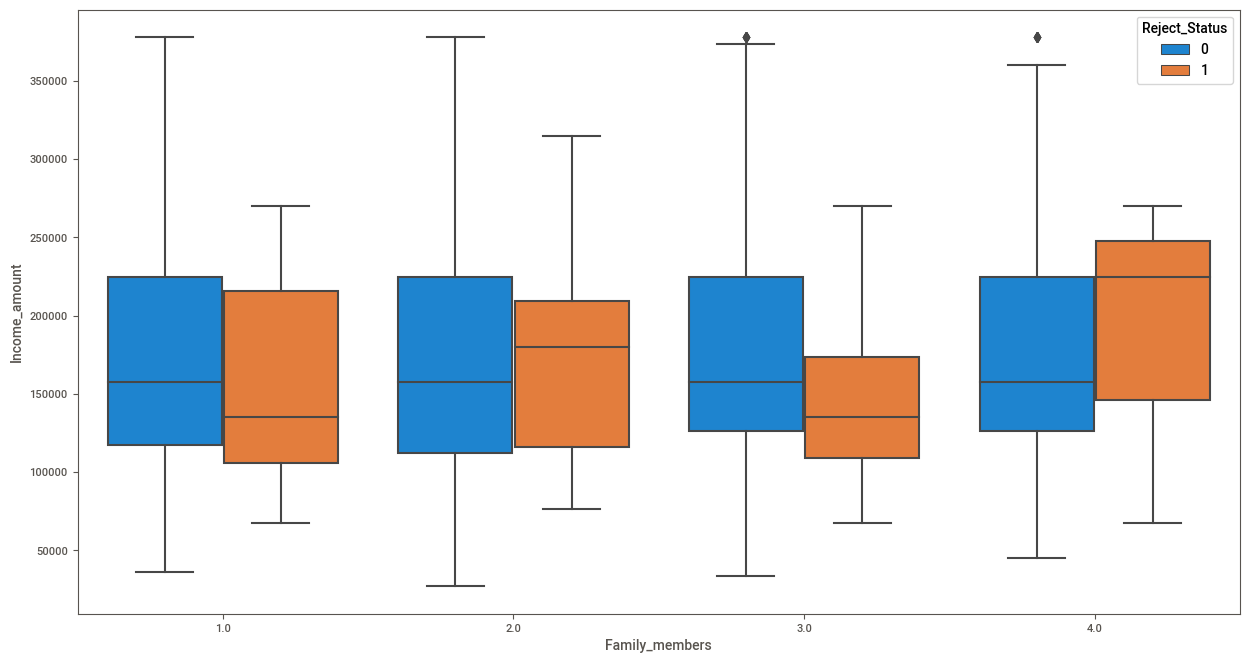

In [49]:
#Remove outliers for children count for 1.5 * IQR
x=1.5
lower_2, upper_2 = remove_outlier(df_IQR1['Children_count'])
df_IQR1N = df_IQR1.loc[(df_IQR1['Children_count'] > lower_2) & (df_IQR1['Children_count'] < upper_2)]
plt.figure(figsize=(15,8))
ax4 = sns.boxplot(x="Family_members", y="Income_amount", hue = "Reject_Status", showfliers = True,data=df_IQR1N)

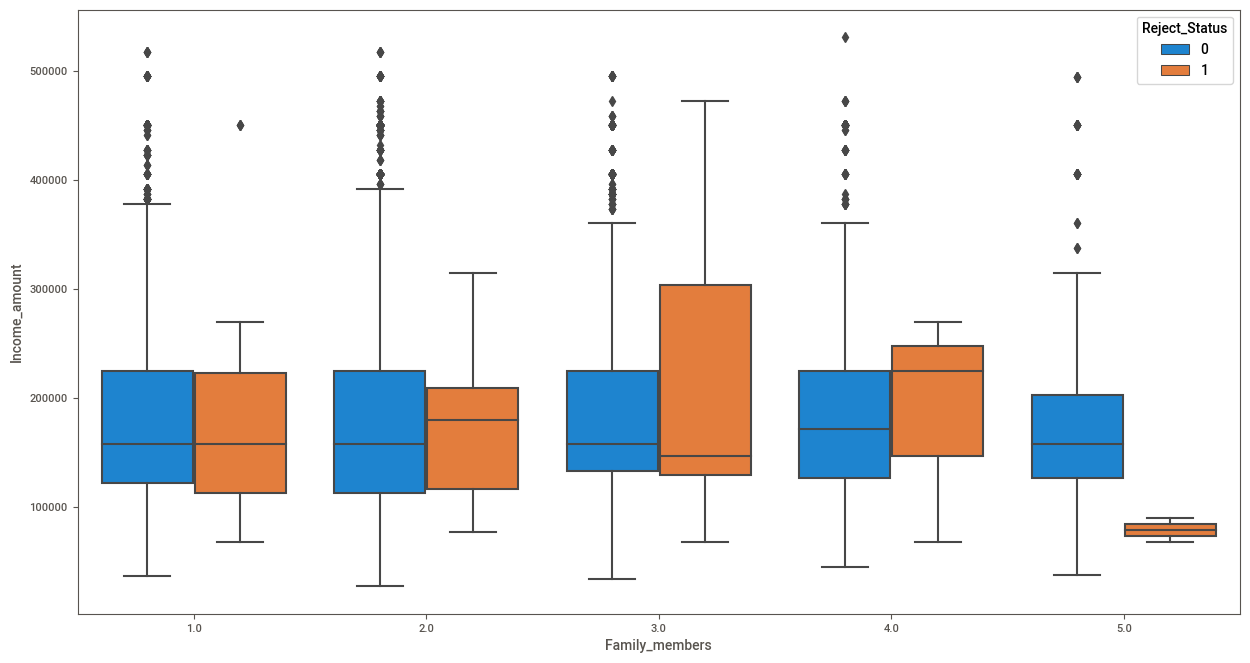

In [50]:
#Remove outliers for children count for 3 * IQR
x=3
lower_2a, upper_2a = remove_outlier(df_IQR2['Children_count'])
df_IQR2N = df_IQR2.loc[(df_IQR2['Children_count'] > lower_2a) & (df_IQR2['Children_count'] < upper_2a)]
plt.figure(figsize=(15,8))
ax5 = sns.boxplot(x="Family_members", y="Income_amount", hue = "Reject_Status", showfliers = True,data=df_IQR2N)

In [51]:
a = df.shape[0] - df_IQR2N.shape[0]
print("Outlier Count = ",a,"\nOutlier % = ",round(((a/df.shape[0])*100),2))

Outlier Count =  550 
Outlier % =  1.51


In [52]:
df_IQR2N['Reject_Status'].value_counts()

0    35802
1      105
Name: Reject_Status, dtype: int64

In [53]:
df_IQR1N['Reject_Status'].value_counts()

0    34361
1       94
Name: Reject_Status, dtype: int64

In [54]:
#df_IQR2N.to_csv('df_IQR2N.csv',index=False)

In [55]:
df_IQR2N.head()

,User_id,Gender,Car,Realty_owned,Children_count,Income_amount,Income_type,Education,Family_status,Housing_type,Work_phone,Phone,Email,Occupation_type,Family_members,Tenure,Reject_Status,Age,Years_employed
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,Unknown,2.0,15,0,33.0,12.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,Unknown,2.0,14,0,33.0,12.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2.0,29,0,59.0,3.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,4,0,52.0,8.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,26,0,52.0,8.0


#### Observation
- 1.5% of data was removed as outliers. And most of these data points belong to the class approved and hence outlier treatment helped indirectly with class imbalance

#### Encoding with target variable
- Target encoding is a simple and quick encoding method that doesn’t add to the dimensionality of the dataset
- Weight-of-evidence encoding is a widely used technique in credit risk modelling which gets the maximum difference among the unique categories in each variable related to the target.

In [56]:
df_IQR2N = df_IQR2N[['User_id','Gender','Car','Realty_owned','Children_count','Income_amount','Income_type','Education',
                     'Family_status','Housing_type','Work_phone','Phone','Email','Occupation_type','Family_members',
                     'Age','Years_employed','Tenure','Reject_Status']]

In [57]:
# Reset Index

df_new = df_IQR2N
#df_new = df_new.set_index('User_id')
#df_new.head(2)

In [58]:
df_new.head()

,User_id,Gender,Car,Realty_owned,Children_count,Income_amount,Income_type,Education,Family_status,Housing_type,Work_phone,Phone,Email,Occupation_type,Family_members,Age,Years_employed,Tenure,Reject_Status
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,Unknown,2.0,33.0,12.0,15,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,Unknown,2.0,33.0,12.0,14,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2.0,59.0,3.0,29,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,52.0,8.0,4,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1.0,52.0,8.0,26,0


In [59]:
df_1 = df_new.copy()

In [60]:
df_2 = df_new.copy()

In [61]:
# split into input and output elements
x_1  = df_1.iloc[:, 1:-1]
y_1 = df_1.iloc[:, -1]

# Test Train Split for category encoding
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_1, y_1, test_size=0.3, random_state=1)

In [62]:
# Encoding binary variables Gender, Realty_owned and Car

le = LabelEncoder()

#Apply to train data

x_1_train.loc[:, 'Gender'] = le.fit_transform(x_1_train.loc[:, 'Gender'])
x_1_train.loc[:, 'Car'] = le.fit_transform(x_1_train.loc[:, 'Car'])
x_1_train.loc[:, 'Realty_owned'] = le.fit_transform(x_1_train.loc[:, 'Realty_owned'])


#Apply to test data

x_1_test.loc[:, 'Gender'] = le.fit_transform(x_1_test.loc[:, 'Gender'])
x_1_test.loc[:, 'Car'] = le.fit_transform(x_1_test.loc[:, 'Car'])
x_1_test.loc[:, 'Realty_owned'] = le.fit_transform(x_1_test.loc[:, 'Realty_owned'])

In [63]:
# One Hot Encoding

#Apply for train dataset

onehot = OneHotEncoder(sparse=False, drop='first', handle_unknown='error')
nominal = onehot.fit_transform(x_1_train[['Income_type', 'Education', 'Family_status', 'Housing_type', 'Occupation_type']])
df_nominal = pd.DataFrame(index=x_1_train.index, data=nominal,
                          columns=onehot.get_feature_names(['Income_type', 'Education', 'Family_status', 'Housing_type',
                                                            'Occupation_type']))
x_1_train = pd.concat([x_1_train, df_nominal], axis=1)
x_1_train.drop(columns=['Income_type', 'Education', 'Family_status', 'Housing_type', 'Occupation_type'], inplace=True)
x_1_train.head()

,Gender,Car,Realty_owned,Children_count,Income_amount,Work_phone,Phone,Email,Family_members,Age,Years_employed,Tenure,Income_type_Pensioner,Income_type_State servant,Income_type_Student,Income_type_Working,Education_Higher education,Education_Incomplete higher,Education_Lower secondary,Education_Secondary / secondary special,Family_status_Married,Family_status_Separated,Family_status_Single / not married,Family_status_Widow,Housing_type_House / apartment,Housing_type_Municipal apartment,Housing_type_Office apartment,Housing_type_Rented apartment,Housing_type_With parents,Occupation_type_Cleaning staff,Occupation_type_Cooking staff,Occupation_type_Core staff,Occupation_type_Drivers,Occupation_type_HR staff,Occupation_type_High skill tech staff,Occupation_type_IT staff,Occupation_type_Laborers,Occupation_type_Low-skill Laborers,Occupation_type_Managers,Occupation_type_Medicine staff,Occupation_type_Private service staff,Occupation_type_Realty agents,Occupation_type_Sales staff,Occupation_type_Secretaries,Occupation_type_Security staff,Occupation_type_Unknown,Occupation_type_Waiters/barmen staff
32327,1,1,0,1,315000.0,1,1,0,3.0,32.0,2.0,13,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18262,0,0,1,0,180000.0,0,1,0,2.0,55.0,0.0,14,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22270,0,0,0,0,117000.0,0,0,0,2.0,57.0,6.0,11,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32953,0,0,1,0,112500.0,0,1,0,2.0,51.0,17.0,29,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5049,0,0,1,2,180000.0,1,1,0,4.0,38.0,19.0,58,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
#Apply for test dataset

nominal_test = onehot.fit_transform(x_1_test[['Income_type', 'Education', 'Family_status', 'Housing_type', 'Occupation_type']])
df_nominal_test = pd.DataFrame(index=x_1_test.index, data=nominal_test,
                          columns=onehot.get_feature_names(['Income_type', 'Education', 'Family_status', 'Housing_type',
                                                            'Occupation_type']))
x_1_test = pd.concat([x_1_test, df_nominal_test], axis=1)
x_1_test.drop(columns=['Income_type', 'Education', 'Family_status', 'Housing_type', 'Occupation_type'], inplace=True)
x_1_test.head()

,Gender,Car,Realty_owned,Children_count,Income_amount,Work_phone,Phone,Email,Family_members,Age,Years_employed,Tenure,Income_type_Pensioner,Income_type_State servant,Income_type_Student,Income_type_Working,Education_Higher education,Education_Incomplete higher,Education_Lower secondary,Education_Secondary / secondary special,Family_status_Married,Family_status_Separated,Family_status_Single / not married,Family_status_Widow,Housing_type_House / apartment,Housing_type_Municipal apartment,Housing_type_Office apartment,Housing_type_Rented apartment,Housing_type_With parents,Occupation_type_Cleaning staff,Occupation_type_Cooking staff,Occupation_type_Core staff,Occupation_type_Drivers,Occupation_type_HR staff,Occupation_type_High skill tech staff,Occupation_type_IT staff,Occupation_type_Laborers,Occupation_type_Low-skill Laborers,Occupation_type_Managers,Occupation_type_Medicine staff,Occupation_type_Private service staff,Occupation_type_Realty agents,Occupation_type_Sales staff,Occupation_type_Secretaries,Occupation_type_Security staff,Occupation_type_Unknown,Occupation_type_Waiters/barmen staff
26384,0,1,1,0,90000.0,0,1,1,2.0,34.0,2.0,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17494,0,1,1,0,216000.0,0,0,0,2.0,58.0,10.0,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23505,0,0,0,0,112500.0,1,0,0,2.0,39.0,4.0,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7491,0,0,1,0,121500.0,1,1,0,2.0,35.0,1.0,27,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8176,1,1,1,0,202500.0,0,1,0,2.0,55.0,1.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(array([13153.,  5612.,  2983.,  1723.,   713.,   438.,   319.,   110.,
           47.,    36.]),
 array([ 0. ,  4.3,  8.6, 12.9, 17.2, 21.5, 25.8, 30.1, 34.4, 38.7, 43. ]),
 <BarContainer object of 10 artists>)

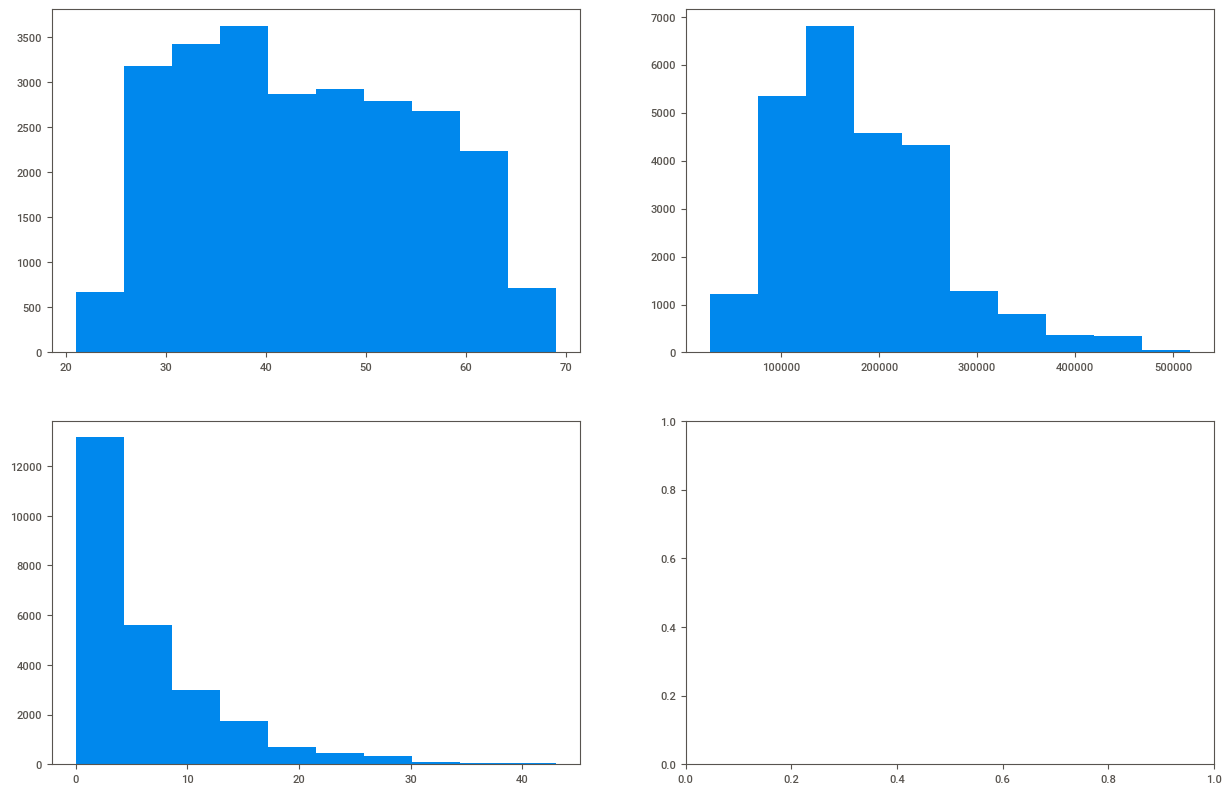

In [65]:
# Continuous numerical variables: Income_amount, Age, Years_employed

fig, ax = plt.subplots(2,2,figsize=(15,10))

ax[0][0].hist(x_1_train['Age'])
ax[0][1].hist(x_1_train['Income_amount'])
ax[1][0].hist(x_1_train['Years_employed'])

In [66]:
# Adaptive binning (quantiles - Quantiles are specific values or cut-points which help in partitioning the 
# continuous valued distribution of a specific numeric field into discrete contiguous bins or intervals


#Apply to train dataset

x_1_train['Age_adabin'] = pd.qcut(x_1_train['Age'], q=[0, .25, .50, .75, 1])
x_1_train['Income_amount_adabin'] = pd.qcut(x_1_train['Income_amount'], q=[0, .25, .50, .75, 1])
x_1_train['Years_employed_adabin'] = pd.qcut(x_1_train['Years_employed'], q=[0, .25, .50, .75, 1])

x_1_train.drop(columns=['Age', 'Income_amount', 'Years_employed'], inplace=True)

#Since each category is divided into 5 equal bins, we can apply Label Encoder without bias

x_1_train['Age'] = le.fit_transform(x_1_train['Age_adabin'])
x_1_train['Income_amount'] = le.fit_transform(x_1_train['Income_amount_adabin'])
x_1_train['Years_employed'] = le.fit_transform(x_1_train['Years_employed_adabin'])

x_1_train.drop(columns=['Age_adabin','Income_amount_adabin', 'Years_employed_adabin'],inplace=True)

x_1_train.head()

,Gender,Car,Realty_owned,Children_count,Work_phone,Phone,Email,Family_members,Tenure,Income_type_Pensioner,Income_type_State servant,Income_type_Student,Income_type_Working,Education_Higher education,Education_Incomplete higher,Education_Lower secondary,Education_Secondary / secondary special,Family_status_Married,Family_status_Separated,Family_status_Single / not married,Family_status_Widow,Housing_type_House / apartment,Housing_type_Municipal apartment,Housing_type_Office apartment,Housing_type_Rented apartment,Housing_type_With parents,Occupation_type_Cleaning staff,Occupation_type_Cooking staff,Occupation_type_Core staff,Occupation_type_Drivers,Occupation_type_HR staff,Occupation_type_High skill tech staff,Occupation_type_IT staff,Occupation_type_Laborers,Occupation_type_Low-skill Laborers,Occupation_type_Managers,Occupation_type_Medicine staff,Occupation_type_Private service staff,Occupation_type_Realty agents,Occupation_type_Sales staff,Occupation_type_Secretaries,Occupation_type_Security staff,Occupation_type_Unknown,Occupation_type_Waiters/barmen staff,Age,Income_amount,Years_employed
32327,1,1,0,1,1,1,0,3.0,13,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,1
18262,0,0,1,0,0,1,0,2.0,14,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3,2,0
22270,0,0,0,0,0,0,0,2.0,11,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3,0,2
32953,0,0,1,0,0,1,0,2.0,29,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,3
5049,0,0,1,2,1,1,0,4.0,58,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,3


In [67]:
#Apply to test dataset

x_1_test['Age_adabin'] = pd.qcut(x_1_test['Age'], q=[0, .25, .50, .75, 1])
x_1_test['Income_amount_adabin'] = pd.qcut(x_1_test['Income_amount'], q=[0, .25, .50, .75, 1])
x_1_test['Years_employed_adabin'] = pd.qcut(x_1_test['Years_employed'], q=[0, .25, .50, .75, 1])

x_1_test.drop(columns=['Age', 'Income_amount', 'Years_employed'], inplace=True)

#Since each category is divided into 5 equal bins, we can apply Label Encoder without bias

x_1_test['Age'] = le.fit_transform(x_1_test['Age_adabin'])
x_1_test['Income_amount'] = le.fit_transform(x_1_test['Income_amount_adabin'])
x_1_test['Years_employed'] = le.fit_transform(x_1_test['Years_employed_adabin'])

x_1_test.drop(columns=['Age_adabin','Income_amount_adabin', 'Years_employed_adabin'],inplace=True)

x_1_test.head()

,Gender,Car,Realty_owned,Children_count,Work_phone,Phone,Email,Family_members,Tenure,Income_type_Pensioner,Income_type_State servant,Income_type_Student,Income_type_Working,Education_Higher education,Education_Incomplete higher,Education_Lower secondary,Education_Secondary / secondary special,Family_status_Married,Family_status_Separated,Family_status_Single / not married,Family_status_Widow,Housing_type_House / apartment,Housing_type_Municipal apartment,Housing_type_Office apartment,Housing_type_Rented apartment,Housing_type_With parents,Occupation_type_Cleaning staff,Occupation_type_Cooking staff,Occupation_type_Core staff,Occupation_type_Drivers,Occupation_type_HR staff,Occupation_type_High skill tech staff,Occupation_type_IT staff,Occupation_type_Laborers,Occupation_type_Low-skill Laborers,Occupation_type_Managers,Occupation_type_Medicine staff,Occupation_type_Private service staff,Occupation_type_Realty agents,Occupation_type_Sales staff,Occupation_type_Secretaries,Occupation_type_Security staff,Occupation_type_Unknown,Occupation_type_Waiters/barmen staff,Age,Income_amount,Years_employed
26384,0,1,1,0,0,1,1,2.0,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
17494,0,1,1,0,0,0,0,2.0,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2,3
23505,0,0,0,0,1,0,0,2.0,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1
7491,0,0,1,0,1,1,0,2.0,27,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
8176,1,1,1,0,0,1,0,2.0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2,0


In [68]:
# split into input and output elements
x_2  = df_2.iloc[:, 1:-1]
y_2 = df_2.iloc[:, -1]

# Test Train Split for category encoding
x_2_train, x_2_test, y_2_train, y_2_test = train_test_split(x_2, y_2, test_size=0.3, random_state=1)

In [69]:
# WOE Encoding

woe = ce.WOEEncoder()

def woe_encoder(col, target):
    for i in range(len(x_2_train.columns)):
        col.iloc[:,i] = woe.fit_transform(col, target)
    return col

df_woe_train = woe_encoder(x_2_train, y_2_train)
df_woe_train.head()

,Gender,Car,Realty_owned,Children_count,Income_amount,Income_type,Education,Family_status,Housing_type,Work_phone,Phone,Email,Occupation_type,Family_members,Age,Years_employed,Tenure
32327,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243
18262,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458
22270,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458
32953,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458
5049,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458


In [70]:
df_woe_test = woe_encoder(x_2_test, y_2_test)
df_woe_test.head()

,Gender,Car,Realty_owned,Children_count,Income_amount,Income_type,Education,Family_status,Housing_type,Work_phone,Phone,Email,Occupation_type,Family_members,Age,Years_employed,Tenure
26384,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493
17494,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493
23505,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493
7491,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493
8176,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995


In [71]:
# Target Encoding

y_2_train = pd.to_numeric(y_2_train)
y_2_test = pd.to_numeric(y_2_test)

from category_encoders import TargetEncoder

te = TargetEncoder()

def target_encoder(col, target):
    for i in range(len(x_2_train.columns)):
        col.iloc[:,i] = te.fit_transform(col, target)
    return col

df_te_train = target_encoder(x_2_train, y_2_train)
df_te_train.head()

,Gender,Car,Realty_owned,Children_count,Income_amount,Income_type,Education,Family_status,Housing_type,Work_phone,Phone,Email,Occupation_type,Family_members,Age,Years_employed,Tenure
32327,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243,0.234243
18262,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458
22270,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458
32953,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458
5049,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458,-0.138458


In [72]:
df_te_test = target_encoder(x_2_test, y_2_test)
df_te_test.head()

,Gender,Car,Realty_owned,Children_count,Income_amount,Income_type,Education,Family_status,Housing_type,Work_phone,Phone,Email,Occupation_type,Family_members,Age,Years_employed,Tenure
26384,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493
17494,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493
23505,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493
7491,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493,-0.074493
8176,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995,0.137995


## Feature Scaling
- Robust Scaler shrinks data to medians and quantiles, thus not influenced by outliers. Hence robust scalar will be used here

In [73]:
# df_1 dataset
x_1_train_rs = pd.DataFrame(RobustScaler().fit_transform(x_1_train), columns=x_1_train.columns)
x_1_test_rs = pd.DataFrame(RobustScaler().fit_transform(x_1_test), columns=x_1_test.columns)

In [74]:
x_1_train.head()

,Gender,Car,Realty_owned,Children_count,Work_phone,Phone,Email,Family_members,Tenure,Income_type_Pensioner,Income_type_State servant,Income_type_Student,Income_type_Working,Education_Higher education,Education_Incomplete higher,Education_Lower secondary,Education_Secondary / secondary special,Family_status_Married,Family_status_Separated,Family_status_Single / not married,Family_status_Widow,Housing_type_House / apartment,Housing_type_Municipal apartment,Housing_type_Office apartment,Housing_type_Rented apartment,Housing_type_With parents,Occupation_type_Cleaning staff,Occupation_type_Cooking staff,Occupation_type_Core staff,Occupation_type_Drivers,Occupation_type_HR staff,Occupation_type_High skill tech staff,Occupation_type_IT staff,Occupation_type_Laborers,Occupation_type_Low-skill Laborers,Occupation_type_Managers,Occupation_type_Medicine staff,Occupation_type_Private service staff,Occupation_type_Realty agents,Occupation_type_Sales staff,Occupation_type_Secretaries,Occupation_type_Security staff,Occupation_type_Unknown,Occupation_type_Waiters/barmen staff,Age,Income_amount,Years_employed
32327,1,1,0,1,1,1,0,3.0,13,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,1
18262,0,0,1,0,0,1,0,2.0,14,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3,2,0
22270,0,0,0,0,0,0,0,2.0,11,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3,0,2
32953,0,0,1,0,0,1,0,2.0,29,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,3
5049,0,0,1,2,1,1,0,4.0,58,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,3


In [75]:
# df_2 dataset
x_2_train_rs = pd.DataFrame(RobustScaler().fit_transform(x_2_train), columns=x_2_train.columns)
x_2_test_rs = pd.DataFrame(RobustScaler().fit_transform(x_2_test), columns=x_2_test.columns)

## Class Imabalance

- Random Undersampling randomly select data from the majority class to delete from the dataset which might result in information loss during modeling
- SMOTE (Oversampling) duplicates data from the minority class which helps balance the distribution but does not provide any additional information to the model

In [76]:
a_target_0 = df_1[df_1['Reject_Status'] == 0].Reject_Status.count() / df_1['Reject_Status'].count()
a_target_1 = df_1[df_1['Reject_Status'] == 1].Reject_Status.count() / df_1['Reject_Status'].count()

print(round(a_target_0,4))
print(round(a_target_1,4))

0.9971
0.0029


In [77]:
# SMOTE Oversampling - Synthetic Minority Oversampling Technique
oversample = SMOTE()

#Apply to train data
x_1_train_rs_over, y_1_train_over = oversample.fit_resample(x_1_train_rs, y_1_train)
print(Counter(y_1_train_over))

Counter({0: 25059, 1: 25059})


In [78]:
#Apply to test data
x_1_test_rs_over, y_1_test_over = oversample.fit_resample(x_1_test_rs, y_1_test)
print(Counter(y_1_test_over))

Counter({0: 10743, 1: 10743})


In [79]:
#df_2 dataset
#Apply to train data
x_2_train_rs_over, y_2_train_over = oversample.fit_resample(x_2_train_rs, y_2_train)
print(Counter(y_2_train_over))

#Apply to test data
x_2_test_rs_over, y_2_test_over = oversample.fit_resample(x_2_test_rs, y_2_test)
print(Counter(y_2_test_over))

Counter({0: 25059, 1: 25059})
Counter({0: 10743, 1: 10743})


## Feature Selection // Dimensionality Reduction

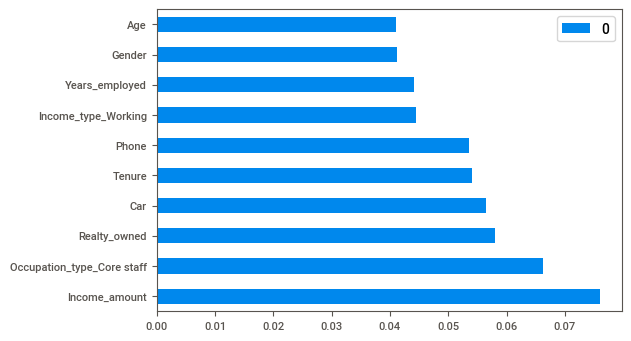

In [80]:
# Feature Importance

fi = ExtraTreesClassifier()
fi_1 = fi.fit(x_1_train_rs_over, y_1_train_over)

df_fi_1 = pd.DataFrame(fi_1.feature_importances_,index=x_1_train_rs_over.columns)
df_fi_1.nlargest(10,df_fi_1.columns).plot(kind='barh')
plt.show()

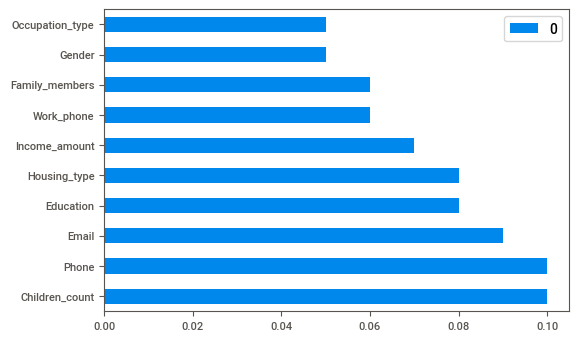

In [81]:
#df_2 dataset

fi_2 = fi.fit(x_2_train_rs_over, y_2_train_over)

df_fi_2 = pd.DataFrame(fi_2.feature_importances_,index=x_2_train_rs_over.columns)
df_fi_2.nlargest(10,df_fi_2.columns).plot(kind='barh')
plt.show()

Email                                 0.066676
Housing_type_Municipal apartment      0.067197
Gender                                0.068093
Family_status_Widow                   0.070700
Income_amount                         0.082655
Housing_type_With parents             0.084733
Family_status_Single / not married    0.089796
Income_type_Pensioner                 0.090843
Occupation_type_Core staff            0.240786
Reject_Status                         1.000000
Name: Reject_Status, dtype: float64


<AxesSubplot:>

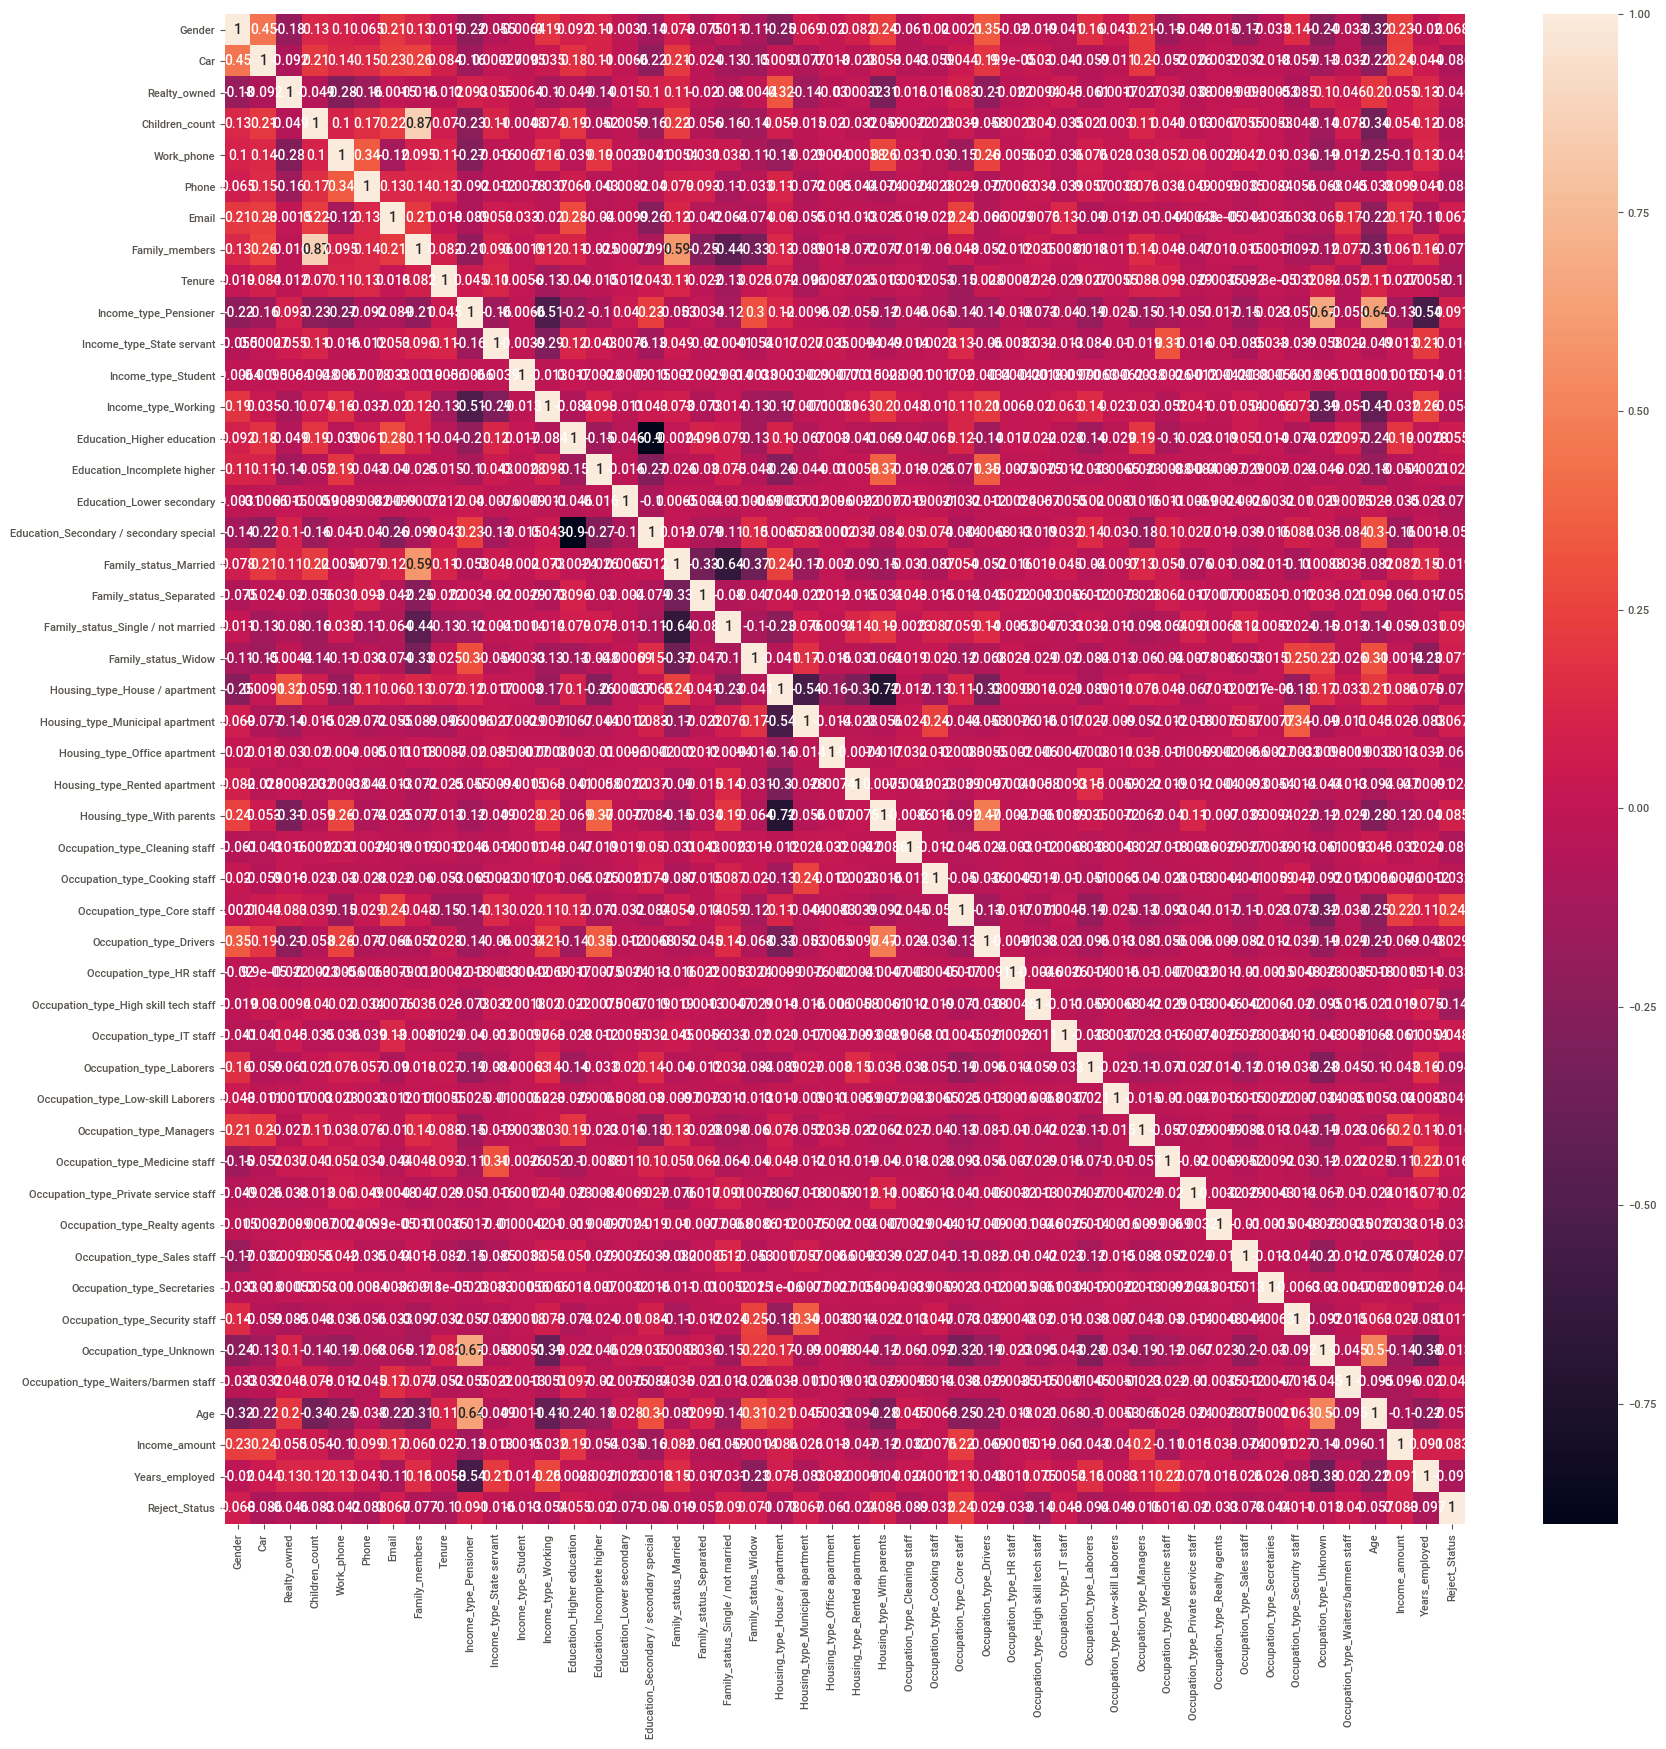

In [82]:
#df_1 dataset

df_1_train_processed = pd.concat([x_1_train_rs_over, y_1_train_over], axis=1) #combine processed features with their target

cm_1 = df_1_train_processed.corr()

print(cm_1['Reject_Status'].sort_values().tail(10))

plt.figure(figsize=(20,20))
sns.heatmap(cm_1, xticklabels=df_1_train_processed.columns, yticklabels=df_1_train_processed.columns,annot=True)

- PCA groups variables by their correlations, and each group is condisidered as a factor
- PCA creates a new set of variables with a smaller set of factors that are uncorrelated in such a way that 1st PC explains maximum variance, followed by 2nd and so on (n_components)

23


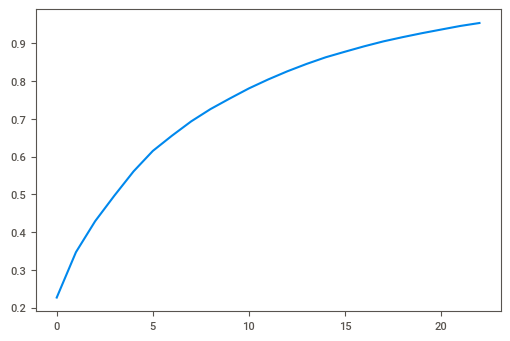

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,1.647296,-0.700632,1.115562,0.808599,0.281171,-0.269333,-0.020388,0.911551,-0.284372,-0.409374,0.521299,-0.131058,-0.638526,-0.008699,0.423957,0.371813,-0.046814,-0.075546,-0.229143,0.149301,0.201201,0.122931,0.146416
1,-0.929873,1.204464,0.102917,0.091661,0.295887,-0.554953,0.066553,0.627518,0.135721,-0.215051,0.056582,-0.003286,-0.586307,0.319511,0.559437,0.488221,0.041245,-0.515152,-0.335150,0.107747,-0.053277,-0.005132,0.174043
2,-0.610468,0.423678,-0.834810,-0.213329,0.482530,0.020941,-0.858475,0.314689,-0.146047,-0.507221,-0.136429,-0.091571,0.729039,0.328191,-0.226102,-0.148638,0.058951,-0.187550,0.252361,-0.017430,-0.203069,-0.173263,0.126738
3,-0.491247,0.178281,-0.788100,-0.337921,-0.440699,1.036412,0.255925,0.483342,-0.462821,0.574633,0.499321,0.318443,0.177842,0.340090,0.331607,-0.001746,0.641378,-0.002527,-0.168034,-0.436728,-0.280362,-0.411686,0.001928
4,2.657735,0.555632,-0.052926,0.049305,-0.634167,1.530599,0.137322,0.131359,0.235799,-0.321685,-0.730919,-0.353494,-0.350430,0.252281,0.487724,-0.020758,-0.317781,-0.005831,0.006313,0.038642,0.130378,0.071587,-0.124519


In [84]:
# PCA on df_1 dataset

df_1_train_processed.shape

pca = PCA(.95)

pca_1_train = pca.fit(x_1_train_rs_over, y_1_train_over)
print(pca_1_train.n_components_)

plt.plot(np.cumsum(pca_1_train.explained_variance_ratio_))
plt.show()

x_1_train_rs_over_pca = pd.DataFrame(pca_1_train.transform(x_1_train_rs_over))
x_1_train_rs_over_pca.head()

 - 15 principal components are able to able to explain >80% of various and seems to be a decent number of feature

In [85]:
#Apply PCA on test data

pca_1_test = pca.fit(x_1_test_rs_over, y_1_test_over)
print(pca_1_test.n_components_)

x_1_test_rs_over_pca = pd.DataFrame(pca_1_test.transform(x_1_test_rs_over))
x_1_test_rs_over_pca.head()

23


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,-0.042052,0.085159,-0.564467,-0.006440,0.288954,-0.355816,-0.399366,-0.577240,-0.197842,-0.455925,0.396509,1.460443,0.045106,-0.361194,0.425493,0.207737,-0.304735,-0.012465,-0.120790,0.203657,-0.034802,-0.257212,0.010695
1,-0.167865,-0.837562,0.321522,-0.627308,-0.448780,-0.623390,-0.166447,0.865170,-0.125004,0.345503,-0.737322,0.147216,0.280890,-0.272192,0.031889,0.150574,0.220007,-0.513817,-0.489966,0.212632,0.245709,0.074145,-0.087213
2,0.013160,-0.200881,-1.266742,0.559418,0.099402,0.329971,0.504972,0.378059,0.308348,0.538859,-0.080161,-0.171491,0.276188,-0.336327,-0.182306,0.456072,0.797812,0.631198,-0.302852,-0.380119,0.141512,0.528866,0.118382
3,-0.240510,0.312855,-1.194063,0.226179,0.533969,0.215119,0.344473,0.568008,0.059047,-0.911997,-0.042078,0.261564,-0.054020,0.033368,-0.139839,0.031919,0.071006,0.209447,-0.160018,-0.041139,0.149237,-0.222363,-0.031034
4,-0.333995,-0.320349,0.193354,-0.778195,-0.628248,-0.248307,0.910605,0.320166,0.044560,-0.743348,-0.091419,-0.099100,-0.835761,-0.827078,0.210104,0.363465,-0.215777,-0.203333,-0.100522,-0.140534,-0.007730,0.217809,0.192214


In [87]:
# PCA on df_2 dataset - test

pca_2_test = PCA(n_components=11).fit(x_2_test_rs_over, y_2_test_over)
print(pca_2_test.n_components_)

x_2_test_rs_over_pca = pd.DataFrame(pca_2_test.transform(x_2_test_rs_over))
x_2_test_rs_over_pca.head()

11


,0,1,2,3,4,5,6,7,8,9,10
0,-1.432322,-1.650987e-19,4.694045e-17,-5.657683e-17,-3.952271e-17,6.770890e-17,-6.649914e-17,2.746752e-17,-3.629183e-17,7.025863e-17,5.010252e-18
1,-1.432322,-1.650987e-19,4.694045e-17,-5.657683e-17,-3.952271e-17,6.770890e-17,-6.649914e-17,2.746752e-17,-3.629183e-17,7.025863e-17,5.010252e-18
2,-1.432322,-1.650987e-19,4.694045e-17,-5.657683e-17,-3.952271e-17,6.770890e-17,-6.649914e-17,2.746752e-17,-3.629183e-17,7.025863e-17,5.010252e-18
3,-1.432322,-1.650987e-19,4.694045e-17,-5.657683e-17,-3.952271e-17,6.770890e-17,-6.649914e-17,2.746752e-17,-3.629183e-17,7.025863e-17,5.010252e-18
4,2.690784,-8.343183e-17,-2.938738e-17,-1.675991e-16,1.582358e-16,3.995333e-17,-1.098799e-17,3.854270e-17,-3.394697e-17,-1.170886e-16,-1.156737e-17


## Model Building

Below models will be tested
- Logistic Regression, KNearest, SVM, Decision Tree, Random Forest, XGBoost, LightGBM

In [88]:
classifiers = {
    "LogisticRegression" : LogisticRegression(),
    "KNeighbors" : KNeighborsClassifier(),
    "SVC" : SVC(),
    "DecisionTree" : DecisionTreeClassifier(),
    "RandomForest" : RandomForestClassifier(),
    "XGBoost" : XGBClassifier()
}

In [89]:
train_scores = []
test_scores = []

for key, classifier in classifiers.items():
    classifier.fit(x_1_train_rs_over_pca, y_1_train_over)
    train_score = round(classifier.score(x_1_train_rs_over_pca, y_1_train_over),2)
    train_scores.append(train_score)
    test_score = round(classifier.score(x_1_test_rs_over_pca, y_1_test_over),2)
    test_scores.append(test_score)

print(train_scores)
print(test_scores)

[19:15:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.68, 0.99, 0.99, 1.0, 1.0, 1.0]
[0.52, 0.62, 0.64, 0.59, 0.55, 0.64]


In [90]:
train_scores = []
test_scores = []

for key, classifier in classifiers.items():
    classifier.fit(x_1_train_rs_over, y_1_train_over)
    train_score = round(classifier.score(x_1_train_rs_over, y_1_train_over),2)
    train_scores.append(train_score)
    test_score = round(classifier.score(x_1_test_rs_over, y_1_test_over),2)
    test_scores.append(test_score)

print(train_scores)
print(test_scores)

[19:17:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0.7, 0.99, 0.99, 1.0, 1.0, 1.0]
[0.5, 0.7, 0.68, 0.84, 0.75, 0.96]


In [91]:
from sklearn.model_selection import GridSearchCV

params = {
    'learning_rate': [0.05,0.1,0.15,0.2,0.25,0.3],
    'max_depth':[5,10,15],
    'min_child_weight':[6,8,10,12],
    'subsample': [0.6,0.7,0.8,0.9], 
    'colsample_bytree':[0.6,0.7,0.8],
    'gamma':[i/10.0 for i in range(0,5)]
 
}

In [1]:
# Grid Search - This code will take some computational power and time so carefully execute it
gsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5, min_child_weight=1,
                                                 gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic',
                                                 nthread=4, scale_pos_weight=1, seed=354), 
                       param_grid = params, scoring='roc_auc',n_jobs=4, cv=5)

#Fit
gsearch.fit(x_1_train_rs_over, y_1_train_over)

"# Grid Search\ngsearch = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5, min_child_weight=1,\n                                                 gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic',\n                                                 nthread=4, scale_pos_weight=1, seed=354), \n                       param_grid = params, scoring='roc_auc',n_jobs=4, cv=5)\n\n#Fit\ngsearch.fit(x_1_train_rs_over, y_1_train_over)"